In [1]:
#!pip install qulacs
#!pip install matplotlib
#!pip install numpy
#!pip install scipy
#!pip install tqdm

from utility import *

In [2]:
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import time 
import random
from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix,RandomUnitary,DepolarizingNoise
from qulacs.circuit import QuantumCircuitOptimizer

# ランダム量子回路と量子ボリューム


ランダムな量子状態の確立分布はどのようになるかをまず確認しよう。

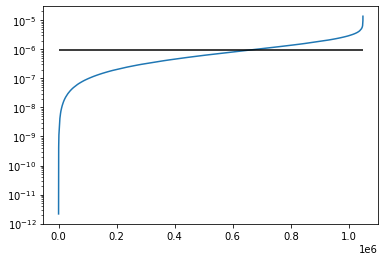

In [3]:
nqubits = 20
state = QuantumState(nqubits)
state.set_Haar_random_state()

#確率分布を取得
prob_dist = [abs(x)**2 for x in state.get_vector()]

#小さい順に並べてプロット
plt.plot(np.sort(prob_dist))
plt.hlines(1/2**nqubits, 0, 2**nqubits, color="black")
plt.yscale("log")
plt.show()

一様分布 $p(x) = \cfrac{1}{2^{nqubits}}$ よりも高い確率で出現するビット列が存在。

## ランダム量子回路
$n$（偶数）量子ビットをランダムにペアに分けて、ランダムな2量子ビット演算を実行するような量子回路を構成しよう。

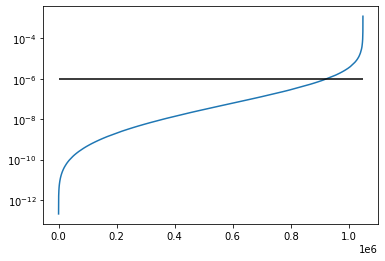

In [4]:
nqubits = 20
depth = 1
state = QuantumState(nqubits)
random_circuit = QuantumCircuit(nqubits)

qubit_index = [i for i in range(nqubits)]

random_circuit_instance =[]

for _ in range(depth):
    #qubitのindexをランダムに置換する
    random.shuffle(qubit_index)
    for k in range(int(nqubits/2)):
        #ランダムに選んだペアにランダム量子演算を作用
        random_circuit_instance.append(RandomUnitary([qubit_index[2*k],qubit_index[2*k+1]]))

#ゲートの総数
gate_counts = len(random_circuit_instance)        

#ゲートを追加
for i in range(gate_counts):
    random_circuit.add_gate(random_circuit_instance[i])

#状態を更新
random_circuit.update_quantum_state(state)

#確率分布を取得
prob_dist = [abs(x)**2 for x in state.get_vector()]

#小さい順に並べてプロット
plt.plot(np.sort(prob_dist))
plt.hlines(1/2**nqubits, 0, 2**nqubits, color="black")
plt.yscale("log")
plt.show()

depthが浅いと少し偏った分布になる。

In [5]:
def random_unitary_gate_set(nqubits,depth):
    random_circuit_instance =[]
    qubit_index = [i for i in range(nqubits)]

    for _ in range(depth):
        #qubitのindexをランダムに置換する
        random.shuffle(qubit_index)
        for k in range(int(nqubits/2)):
            #ランダムに選んだペアにランダム量子演算を作用
            random_circuit_instance.append(RandomUnitary([qubit_index[2*k],qubit_index[2*k+1]]))

    return random_circuit_instance

def random_circuit_sampling(nqubits,random_circuit_instance):
    state = QuantumState(nqubits)
    random_circuit = QuantumCircuit(nqubits)

    #ゲートの総数
    gate_counts = len(random_circuit_instance)        

    #ゲートを追加
    for i in range(gate_counts):
        random_circuit.add_gate(random_circuit_instance[i])

    #状態を更新
    random_circuit.update_quantum_state(state)


    #確率分布を取得
    prob_dist = [abs(x)**2 for x in state.get_vector()]

    #小さい順に並べてプロット
    plt.plot(np.sort(prob_dist))
    plt.hlines(1/2**nqubits, 0, 2**nqubits, color="black")
    plt.yscale("log")
    plt.show()

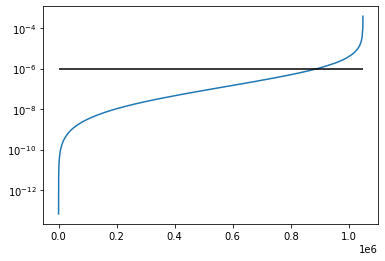

In [6]:
nqubits=20
depth = 2
random_circuit_sampling(nqubits,random_unitary_gate_set(nqubits,depth))

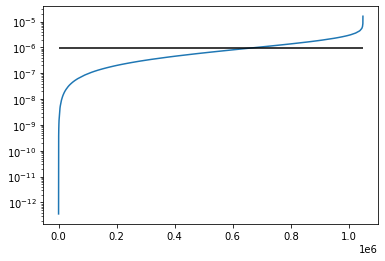

In [7]:
nqubits=20
depth = 10
random_circuit_sampling(nqubits,random_unitary_gate_set(nqubits,depth))

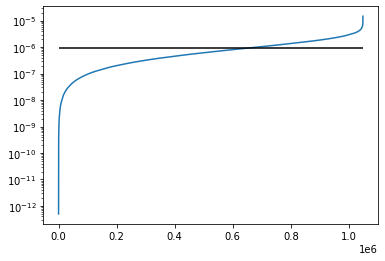

In [8]:
nqubits=20
depth=20
random_circuit_sampling(nqubits,random_unitary_gate_set(nqubits,depth))

## Heavy Output を生成する

In [9]:
def HeavyOutput(nqubits,random_circuit_instance):
    state = QuantumState(nqubits)
    random_circuit = QuantumCircuit(nqubits)

    #ゲートの総数
    gate_counts = len(random_circuit_instance)

    #ゲートを追加
    for i in range(gate_counts):
        random_circuit.add_gate(random_circuit_instance[i])
        

    #状態を更新
    random_circuit.update_quantum_state(state)


    #確率分布を取得
    prob_dist = [abs(x)**2 for x in state.get_vector()]
    
    #小さい順に並べて中央値を取り出す
    p_median = np.sort(prob_dist)[2**(nqubits-1)-1]
    
    heavy_output = []
    for i in range(2**nqubits):
        #中央値よりも確率が高くなる側て結果を集める
        if prob_dist[i] > p_median:
            heavy_output.append(i)
    return heavy_output

In [10]:
nqubits = 2
depth = 2
random_circuit_instance = random_unitary_gate_set(nqubits,depth)

state = QuantumState(nqubits)
random_circuit = QuantumCircuit(nqubits)

#ゲートの総数
gate_counts = len(random_circuit_instance)

#ゲートを追加
for i in range(gate_counts):
    random_circuit.add_gate(random_circuit_instance[i])

#状態を更新
random_circuit.update_quantum_state(state)


#確率分布を取得
prob_dist = [abs(x)**2 for x in state.get_vector()]
#print(prob_dist)

heavy_output = HeavyOutput(nqubits,random_circuit_instance)
#print(heavy_output)

heavy_prob = 0
for i in heavy_output:
    heavy_prob += prob_dist[i]

print(heavy_prob)

0.7213624594994279


さて、$n$量子ビット、深さ$d$のランダム量子回路で、heavy outputを得る確率が$\cfrac{2}{3}$以上だった場合にタスクが成功するとする。このとき、量子ボリュームは、$QV= max( 2^{min(n,d)})$ で定義される。

## 実際にサンプリングをして、heavy outputを得る確率を推定してみよう

理想的な量子回路の場合：

In [11]:
nqubits = 10
depth = nqubits
shots =10000

# random circuitのインスタンスを生成
random_circuit = QuantumCircuit(nqubits)
random_circuit_instance = random_unitary_gate_set(nqubits,depth)

# heavy outputの計算
heavy_output = HeavyOutput(nqubits,random_circuit_instance)

#ゲートの総数
gate_counts = len(random_circuit_instance)

#ゲートを追加
for i in range(gate_counts):
    random_circuit.add_gate(random_circuit_instance[i])

#状態を更新
state = QuantumState(nqubits)
random_circuit.update_quantum_state(state)

#サンプリングを実行
outcome = state.sampling(shots)

counts = 0
for i in outcome:
    if i in heavy_output:
        counts += 1
estimated_heavy_prob = counts/shots    
print(estimated_heavy_prob)

0.851


ノイズのある回路の場合：  
※この処理は実行に時間がかかります。

In [12]:
nqubits = 20
depth = nqubits
shots =1000
error_prob = 0.001

# random circuitのインスタンスを生成
random_circuit_instance = random_unitary_gate_set(nqubits,depth)

# heavy outputの計算
heavy_output = HeavyOutput(nqubits,random_circuit_instance)

#ゲートの総数
gate_counts = len(random_circuit_instance)

#1回のサンプリングをshots回繰り返す（ノイズのインスタンスが毎回かわるため）
counts = 0

for _ in tqdm.tqdm(range(shots)):
    #ゲートを追加
    random_circuit = QuantumCircuit(nqubits)
    for i in range(gate_counts):
        random_circuit.add_gate(random_circuit_instance[i])
        
        #各depthごとにdepolarizing noiseを挿入する
        if i % int(nqubits/2) == 0:
            for k in range(nqubits):
                #１量子ビットのdepolarzingNoiseを作用させる
                random_circuit.add_gate(DepolarizingNoise(k,error_prob))
        

    #状態を更新
    state = QuantumState(nqubits)
    random_circuit.update_quantum_state(state)

    #サンプリングを実行
    outcome = state.sampling(1)

    if outcome[0] in heavy_output:
        counts += 1

estimated_heavy_prob = counts/shots    
print(estimated_heavy_prob)


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [04:05<00:00,  4.08it/s]

0.748
